# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('real_estate_data.csv', sep='\t')

# Выведем первые 5 строк датасета для ознакомления с данными
pd.set_option('display.max_columns', None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
# Посмотрим общую информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

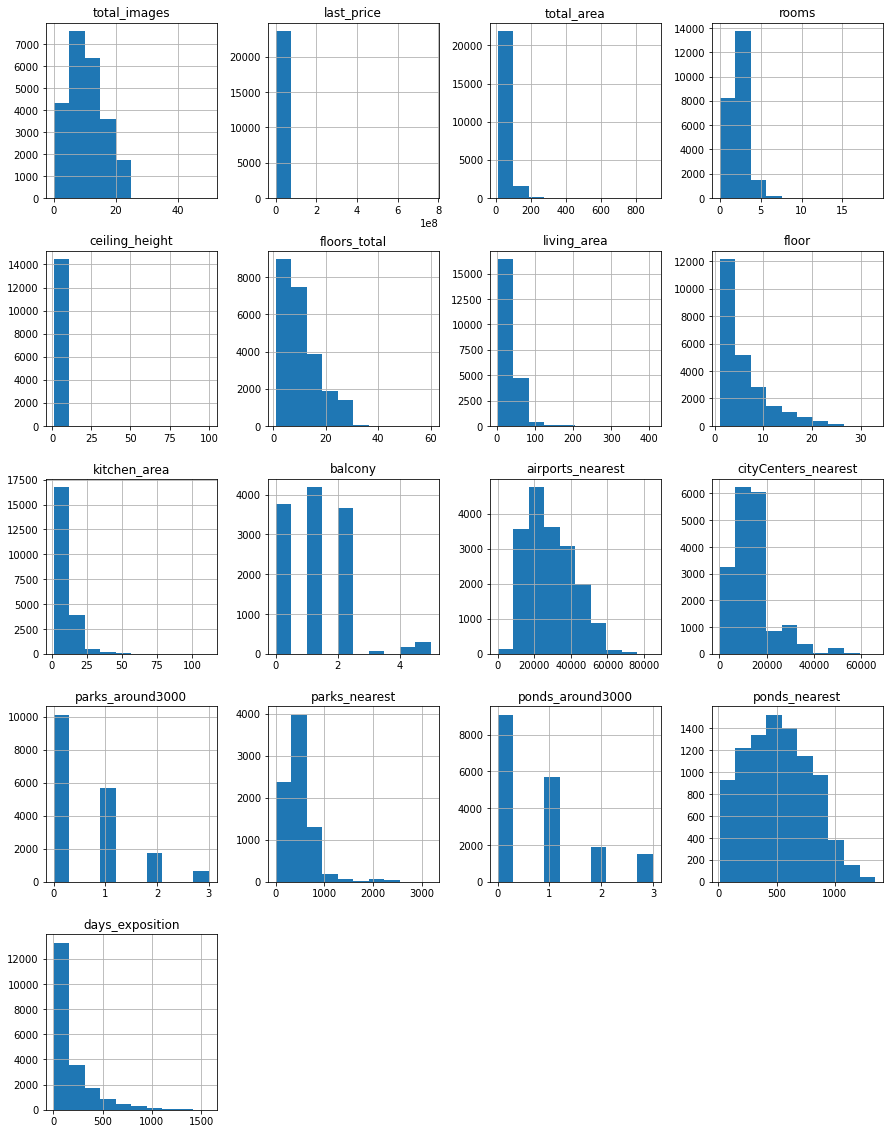

In [4]:
# Построим гистограммы по численным значениям датасета для визуального представления данных
data.hist(figsize=(15, 20));

In [5]:
# Проверим наличие явных дубликатов в данных
data.duplicated().sum()

0

Общее количество строк - 23699.
В столбцах `ceiling_height `, `floors_total`, `living_area`, `is_apartment`, `kitchen_area`, `balcony`, `locality_name`, `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, `days_exposition` есть пропуски в данных, попробуем их устранить, в столбцах с пропусками по картографическим данным мы скорее всего не сожем адекватно заполнить пропуски, их оставим как есть.

Приведем названия столбцов `is_apartment`, `cityCenters_nearest`, `parks_around3000`, `ponds_around3000` к единому виду.

В столбцах `last_price`, `first_day_exposition`, `is_apartment`, `balcony`, `days_expositio` изменим тип данных.

В стобце `locality_name` удалим неявные дубликаты.

Рассмотим данные поближе, при наличии выбивающихся значений удалим их из датасета или восстановим адекватные значения.

### Предобработка данных

В ходе предобработки данных приведем значения в столбцах к одному типу, определим пропуски в данных, заполним пропуски или удалим строки с пропусками, которые мы не можем восстановить, изменим типы данных в стобцах (если необходимо), удалим неявные дубликаты и аномальные значения в данных

#### Приведем названия столбцов к общему виду

In [6]:
data = data.rename(
    columns={
        'cityCenters_nearest': 'city_centers_nearest',
        'parks_around3000': 'parks_around_3000',
        'ponds_around3000': 'ponds_around_3000',
        'is_apartment': 'apartment'
    })

In [7]:
# Определим количество пропусков в процентном соотношении ко всем данным в строке для каждого столбца
(data.isna().sum() / len(data) * 100).round(2)

total_images             0.00
last_price               0.00
total_area               0.00
first_day_exposition     0.00
rooms                    0.00
ceiling_height          38.80
floors_total             0.36
living_area              8.03
floor                    0.00
apartment               88.29
studio                   0.00
open_plan                0.00
kitchen_area             9.61
balcony                 48.61
locality_name            0.21
airports_nearest        23.38
city_centers_nearest    23.29
parks_around_3000       23.28
parks_nearest           65.91
ponds_around_3000       23.28
ponds_nearest           61.56
days_exposition         13.42
dtype: float64

Наибольшее количество пропусков в столбцах `ceiling_height` - **38.8%**, `living_area` - **8.03%**, `apartment` - **88.3%**, `kitchen_area` - **9.61%**, `balcony` - **48,61%**. Необходимо заполнить пропущенные данные в этих столбцах.

Пропущенные данные в столбцах `floors_total` - **0.36%** и `locality_name` - **0.21%** можно удалить т.к. эти данные занимают менее **1%**, что в дальшейшем не повлияет результат анализа.

Пропущенные данные в столбцах `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, `days_exposition` не получится корректно восстановить, также мы не можем удалить столь большой объем данных из датасета, в связи с этими факторами оставим пропуски пустыми.

#### Заполнение пропущенных значений в столбце `balcony`

In [8]:
# Проверим уникальные значения в столбце apartment
data['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

Предположим, что в квартирах где нет балкона не заполнено количество балконов, заполним отсутствующие значение нулём

In [9]:
data['balcony'] = data['balcony'].fillna(value=0)
# Проверим правильность заполнения пропущенных значений
data['balcony'].isna().sum()

0

Тип данных в столбце `float`, заменим тип данных на `int`, т.к. у нас целые значения данных

In [10]:
data['balcony'] = data['balcony'].astype('int')

#### Заполнение пропущенных значений в столбце `apartment` 


In [11]:
# Проверим уникальные значения в столбце apartment
data['apartment'].unique()

array([nan, False, True], dtype=object)

Тип значений столбеца `apartment` -  булевый. Предположим, что большое количество пропусков появилось в связи с тем, что при заполнении объявлений не был заполнен пункт т.к. кварира не является апартаментом. Исходя из этого заполним пропуски значением `False`

In [12]:
data['apartment'] = data['apartment'].fillna(value=False)
# Проверим остались ли еще пропуски
data['apartment'].isna().sum()

0

#### Удаление пропущенных данных в столбцах `floors_total` и `locality_name` 

In [13]:
# Удаляем строки с пропущенными значениями в столбце floors_total и locality_name
data = data.dropna(subset=['floors_total', 'locality_name']).reset_index(drop=True)
# Проверяем количество пропусков в столбцах
data[['floors_total', 'locality_name']].isna().sum()

floors_total     0
locality_name    0
dtype: int64

In [14]:
# Проверим правильная ли индексация
data.tail()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
23560,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.7,5.0,73.3,3,False,False,False,13.83,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23561,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,False,False,False,8.50,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23562,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,False,False,False,NaN,0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23563,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.0,17.0,NaN,12,False,False,False,23.30,2,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23564,4,1350000.0,32.30,2017-07-21T00:00:00,1,2.5,5.0,12.3,1,False,False,False,9.00,0,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Заполнение пропущенных значений в столбце `ceiling_height`
В столбце `ceiling_height` **38.8%** пропусков, мы не можем удалить такое количество данных т.к это может в дальнейшем сильно повлиять на модель или на дальнейший анализ данных.

Т.к в Санкт-Петербурге много исторической застройки c высокими потолками, посмотрим как изменяется высота потолков с удалением от центра города.

<AxesSubplot:xlabel='city_centers_nearest', ylabel='ceiling_height'>

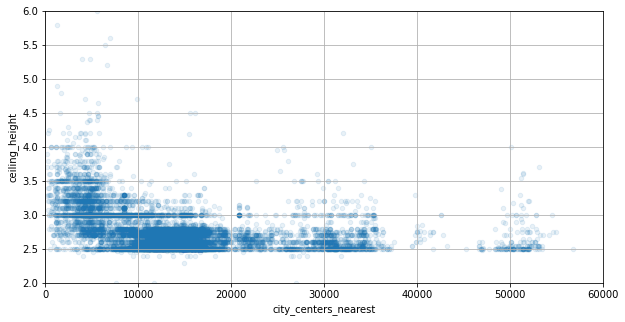

In [15]:
data.plot(x='city_centers_nearest', 
          y='ceiling_height',
          kind='scatter',
          xlim=(0, 60000),
          ylim=(2, 6), 
          alpha=0.1,
          grid=True,
         figsize=(10, 5)
         )

Из графика видно, что высота потолков увеличивается с увеличением расстояния от центра города.

Категоризируем квартиры по удаленности от центра города, чтобы в дальнейшем заменить пропуски данных в соответствии с категорией квартиры.
Выделим 3 категории:
- Город - до 10000 м
- Пригород - 10001 - 40000 м
- Область - более 40000 м

In [16]:
# Добавим дополнительный столец distance_to_center в наш датасет из заполним его
def distance_category(distance):
    try:
        if 0 <= distance <= 10000:
            return 'Город'
        elif 10001 <= distance <= 40000:
            return 'Пригород'
        elif distance >= 40001:
            return 'Область'
    except:
        pass
    
data['distance_to_center'] = data['city_centers_nearest'].apply(distance_category)

In [17]:
# Создадим сводную таблицу по категориям отдаленности от центра с медианными значениями высоты потолка
data.pivot_table(index='distance_to_center', values='ceiling_height', aggfunc='median')

,ceiling_height
distance_to_center,
Город,3.00
Область,2.55
Пригород,2.60


In [18]:
# Заполним пропуски в столбце ceiling_height медианными значениями высоты потолка по каждой категории
data.loc[(data['ceiling_height'].isna() == True) & (data['distance_to_center'] == 'Город'), 'ceiling_height'] = 3
data.loc[(data['ceiling_height'].isna() == True) & (data['distance_to_center'] == 'Область'), 'ceiling_height'] = 2.55
data.loc[(data['ceiling_height'].isna() == True) & (data['distance_to_center'] == 'Пригород'), 'ceiling_height'] = 2.6

In [19]:
data['ceiling_height'].isna().sum()

2560

Осталось 2560 пропущенных значений в стоблце `ceiling_height` это связано с тем, что в столбце `city_centers_nearest` тоже есть пропущенные значения. Заполним пропущенные значения в столбце `ceiling_height` медианным значением по высоте потолков.

In [20]:
# Найдем медианное значение высоты потолка
data['ceiling_height'].median()

2.6

In [21]:
# Заполним оставшиеся пропуски в столбце ceiling_height
data.loc[data['ceiling_height'].isna() == True, 'ceiling_height'] = data['ceiling_height'].median()

# Проверим количество оставшихся пропусков в столбце
data['ceiling_height'].isna().sum()

0

#### Заполенение пропущенных значений в столбце `living_area`
В столбце `living_area` **8%** пропущенных значений, что довольно много для удаления данных.

0.9397711143610333

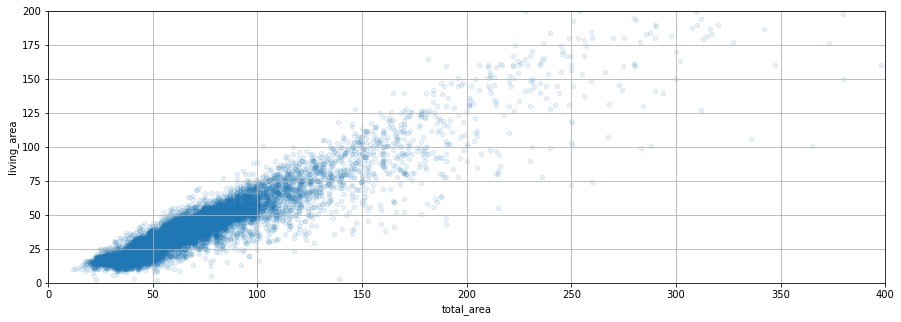

In [22]:
# Построим график для представления данных по общей и жилой площади
data.plot(x='total_area',
          y='living_area',
          kind='scatter',
          xlim=(0, 400),
          ylim=(0, 200),
          alpha=0.1,
          grid=True,
         figsize=(15, 5)
         )

# Посчитаем коэффицент корряляции между общей площадью и жилой площадью
data['total_area'].corr(data['living_area'])

В результате анализа мы видим, что коэффициет корряляции составляет 0.93, что говорит нам о сильной зависимости жилой площади от общей площади квартиры. При представлении данных в графическом виде, мы так же видим линейную зависимость данных. Исходя из этого мы можем линейно заполнить данные применяя коэффициет отношения жилой площади к общей площади.

In [23]:
# Найдем отношение медианной жилой площади и медианной общей площади квартиры
living_total_ratio = data['living_area'].median() / data['total_area'].median()
living_total_ratio

0.5769230769230769

In [24]:
# Заменим отсутствующие значения в стоблце living_area
data['living_area'].fillna(value=(data['total_area'] * living_total_ratio), inplace=True)

# Проверим заменились ли данные
data['living_area'].isna().sum()

0

#### Заполнение пропущенных значений в столбце `kitchen_area`

In [25]:
data['kitchen_area'].isna().sum()

2222

count    21343.000000
mean        10.560994
std          5.900630
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

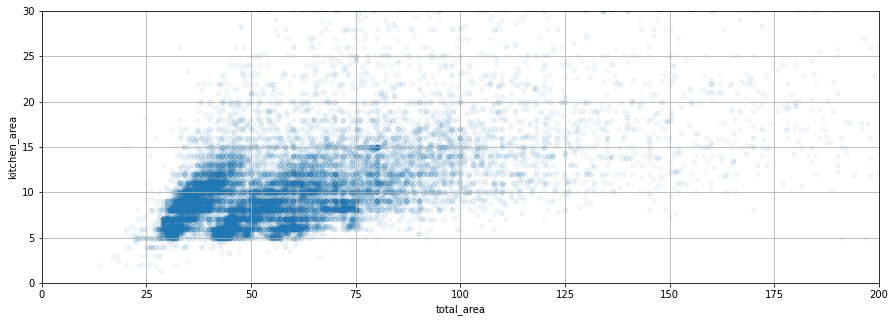

In [26]:
# Построим график для представления отношения данных по общей площади квартиры и площади кухни
data.plot(x='total_area',
          y='kitchen_area',
          kind='scatter',
          xlim=(0, 200),
          ylim=(0, 30),
          alpha=0.05,
          grid=True,
         figsize=(15, 5)
         );

# Отобразим краткое описание данных по площади кухни
data['kitchen_area'].describe()

Данные по площади кухни в основном находятся в районе 5 - 15 кв.м, исходя из этого заполним пропуски **медианным** значением площади кухни, что составляет **9.1 кв.м**. Заполнение пропущенных данных медианным значением не должно сильно повлиять на весь датасет.

In [27]:
data['kitchen_area'] = data['kitchen_area'].fillna(value=data['kitchen_area'].median())

# Проверим количество пропусков в столбце kitchen_area
data['kitchen_area'].isna().sum()

0

Проверим наличие ошибок в данных связаных с тем, что площадь кухни и жилая площадь больше общей площади квартиры.

In [28]:
data[(data['kitchen_area'] + data['living_area']) > data['total_area']].count()['kitchen_area']

328

In [29]:
data[(data['kitchen_area'] + data['living_area']) > data['total_area']].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,distance_to_center
184,7,2600000.0,30.20,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,False,False,False,6.20,0,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0,Пригород
347,4,2320000.0,25.00,2017-09-27T00:00:00,0,2.60,14.0,17.00,1,False,False,True,9.10,0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0,None
438,8,2480000.0,27.11,2018-03-12T00:00:00,0,2.60,17.0,24.75,4,False,True,False,9.10,2,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0,Пригород
542,9,4700000.0,23.80,2018-12-28T00:00:00,1,2.60,18.0,20.00,9,False,False,False,5.00,0,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0,Пригород
548,8,3100000.0,31.59,2018-03-08T00:00:00,1,2.70,19.0,30.55,2,False,False,False,9.28,2,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0,None


Как мы видим в 328 квартирах общая площадь меньше суммированной площади кухни, жилой площади и санузла с коридором.

Т.к по коэффициент корреляции между общей и жилой площадью высокий (**0.94**), предлагается изменить в этих квартирах площадь кухни т.к. существует много квартир с меньшей площадью чем 9.1 кв.м.

In [30]:
data.loc[(data['kitchen_area'] + data['living_area']) > data['total_area'], 'kitchen_area'] = (
    data['total_area'] - (data['living_area']))

In [31]:
data[((data['kitchen_area'] + data['living_area'])) > data['total_area']].count()['kitchen_area']

0

Выведем общую информацию по датасету, чтобы посмотреть остались ли незаполненные пропуски в данных и чтобы посмотреть типы данных в столбцах

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   apartment             23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  int64  
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Как мы видим пропусков в требуемых нам столбцах нет.

#### Изменение типов данных

Изменим тип данных в столбцах `last_price`, `floors_total` на тип `int`, т.к. цена квартиры и количество этажей обычно являются целыми числами.

Фомат данных в столбце `first_day_exposition` - `object`(т.е строка) переведем данные в фомат `datetime` для дальнейшейт работы со временем

In [33]:
data['last_price'] = data['last_price'].astype('int')
data['floors_total'] = data['floors_total'].astype('int')

In [34]:
# Переведем данные в столбце first_day_exposition в тип данных datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [35]:
# Проверим изменился ли тип данных в столбцах
data[['last_price', 'floors_total', 'first_day_exposition']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   last_price            23565 non-null  int64         
 1   floors_total          23565 non-null  int64         
 2   first_day_exposition  23565 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 552.4 KB


Тип данных был изменен

#### Удалим неявные дубликаты в названии населенных пунктов (столбец `locality_name`)

In [36]:
# Выведем и отсортируем все уникальные значения в столбце locality_name
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Видим, что присутвует большое количество неявных дубликатов, к примеру, есть буква **ё** в названии, **городской поселок** - **поселок городского типа** - **поселок** - **посёлок** - по сути одно и тоже.
Для устранения неявных дубликатов заменим букву **ё** на **е** и избавимся от типа населенного пункта в названии, что не помешает нам в дальнейшей работе с данными.

In [37]:
# Заменим букву ё на е
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

In [38]:
# Создадим список со словами, которые необходимо удалить из названий населенных пунктов
location_type_to_del = ['деревня', 'садовое', 'товарищество', 'поселок', 'станции', 'садоводческое',
                        'некоммерческое', 'при', 'железнодорожной', 'станции', 'городского', 'типа', 
                        'городской', 'коттеджный', 'село', 'имени']

# Создадим цикл для перебора спиcка и удаления типов населенных пунктов из столбца
for type in location_type_to_del:
    data['locality_name'] = data['locality_name'].str.replace(type, '')
    
# Удалим лишние пробелы в начале и в конце строки в названиях
data['locality_name'] = data['locality_name'].str.strip()

# Выведем уникальные значения для проверки
data['locality_name'].sort_values().unique()

array(['Агалатово', 'Александровская', 'Алексеевка', 'Аннино', 'Аро',
       'Барышево', 'Батово', 'Бегуницы', 'Белогорка', 'Белоостров',
       'Бокситогорск', 'Большая Вруда', 'Большая Ижора',
       'Большая Пустомержа', 'Большие Колпаны', 'Большое Рейзино',
       'Большой Сабск', 'Бор', 'Борисова Грива', 'Бугры', 'Будогощь',
       'Ваганово', 'Важины', 'Вартемяги', 'Вахнова Кара', 'Вещево',
       'Виллози', 'Вознесенье', 'Возрождение', 'Войсковицы', 'Войскорово',
       'Володарское', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Вырица', 'Выскатка', 'Высокоключевой', 'Высоцк', 'Гаврилово',
       'Гарболово', 'Гатчина', 'Гладкое', 'Глажево', 'Глебычево',
       'Глинка', 'Гончарово', 'Горбунки', 'Гостилицы', 'Громово',
       'Дзержинского', 'Дружная Горка', 'Дружноселье', 'Дубровка',
       'Елизаветино', 'Ефимовский', 'Жил', 'Жилгородок', 'Житково',
       'Заводской', 'Заклинье', 'Заневка', 'Запорожское', 'Зеленогорск',
       'Зимитицы', 'Ивангород', 'Извара', 'Ильи

#### Устранение аномальных значений в столбцах

In [39]:
# Выведем статистики по всем нашим данным для поиска аномальных значений
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,18041.000000,18064.000000,18065.000000,8030.000000,18065.000000,9036.000000,20394.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.734562,10.675875,34.621108,5.878124,10.377360,0.593677,28797.082701,14192.656056,0.611569,490.580448,0.769499,518.289509,180.741395
std,5.681156,1.091093e+07,35.657060,1.078591,0.995178,6.594823,22.399827,4.871485,5.630699,0.960660,12632.499735,8613.348153,0.802088,341.572956,0.938669,278.009558,219.732782
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,19.000000,2.000000,7.200000,0.000000,18565.000000,9238.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.600000,9.000000,30.000000,4.000000,9.100000,0.000000,26757.000000,13096.500000,0.000000,455.000000,1.000000,503.000000,95.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.770000,16.000000,42.115385,8.000000,11.400000,1.000000,37273.000000,16285.000000,1.000000,612.000000,1.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Из таблицы видим, что в столбцах `ceiling_height`, `total_area`, `last_price`, `rooms`, `living_area`, и `kitchen_area` есть аномальные значения.

##### Поиск аномальных значений в столбце `total_area`

Выведем график ящик с усами для оценки аномальных данных в столбце `total_area`

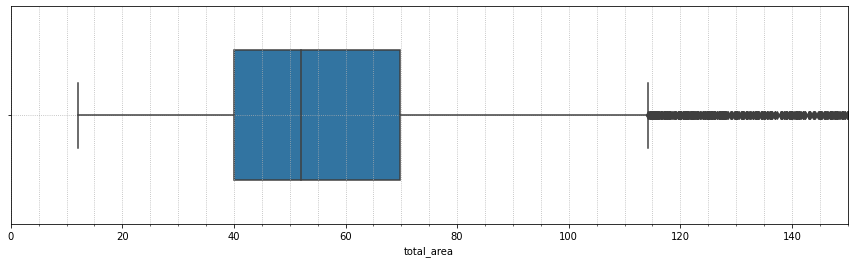

In [40]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.boxplot(data=data, x='total_area', width=0.6)
plt.xlim(0, 150)
plt.minorticks_on()
plt.grid(which='both', linestyle = ':')

По графику ящик с усами, мы видим, что значения выше Q3 + 1.5IQR можно считать выбросами, но квартир более ~115 кв.м довольно много. Отбросим значения превышающее 3 стандартных отклонения.

In [41]:
# Найдем значения превышающие 3 стандартных
data['total_area'].quantile(q=0.5) + (3 * data['total_area'].std())

158.97117875184793

**Квартиры площадью более 158.97 являются нетипичными.**

Проверим минимальные значения в столбце `total_area`.

In [42]:
data.sort_values(by='total_area').head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,distance_to_center
19795,4,2400000,12.0,2017-07-19,1,2.55,5,10.000000,2,False,False,False,2.000000,0,Санкт-Петербург,21314.0,964.0,1.0,886.0,2.0,45.0,200.0,Город
17859,3,1400000,13.0,2017-12-03,1,2.60,9,7.500000,1,False,False,False,5.500000,0,Санкт-Петербург,14350.0,15945.0,0.0,NaN,1.0,185.0,410.0,Пригород
19437,3,1850000,13.0,2019-03-11,1,3.40,5,7.500000,2,False,False,False,5.500000,0,Санкт-Петербург,24915.0,5483.0,1.0,644.0,0.0,NaN,24.0,Город
19698,0,3800000,13.0,2018-07-04,1,3.00,5,10.000000,3,False,False,False,3.000000,0,Санкт-Петербург,21302.0,1242.0,1.0,592.0,3.0,27.0,9.0,Город
19449,2,1686000,13.2,2018-12-17,1,3.00,5,7.615385,1,False,False,False,5.584615,0,Санкт-Петербург,19891.0,4165.0,1.0,361.0,1.0,155.0,19.0,Город


Предполагаю, что в объявлениях указаны не квартиры, а отдельные продающиеся комнаты или комнаты в коммунальных квартирах. **Не будем удалять их из датасета.**

##### Поиск  аномальных значений в столбце `last_price`
Выведем график ящик с усами для оценки аномальных данных в столбце `last_price`

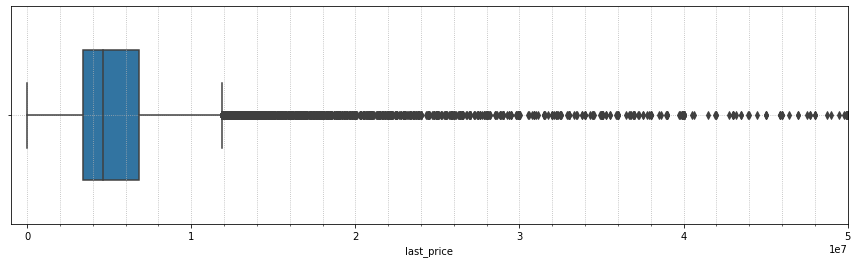

In [43]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.boxplot(data=data, x='last_price', width=0.6)
plt.xlim(-1000_000, 50_000_000)
plt.minorticks_on()
plt.grid(which='both', linestyle = ':')

По графику ящик с усами, мы видим, что значения выше Q3 + 1.5IQR можно считать выбросами, но квартир стоимостью более ~ 12 млн.руб довольно много. Отбросим значения превышающее 3 стандартных отклонения.

In [44]:
data['last_price'].quantile(q=0.5) + (3 * data['last_price'].std())

37378804.1645429

**Квартиры ценой более более 37378804.1 руб являются выбросами.**

In [45]:
data.sort_values(by='last_price').head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,distance_to_center
8750,7,12190,109.0,2019-03-20,2,2.75,25,32.000000,25,False,False,False,40.5,0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0,Город
17359,7,430000,30.4,2019-04-22,1,2.60,2,16.000000,1,False,False,False,6.0,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
14825,5,430000,54.0,2018-06-26,2,2.60,3,31.153846,3,False,False,False,9.1,0,Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0,None
16185,18,440000,40.0,2018-07-10,1,2.60,5,23.076923,1,False,False,False,9.1,0,Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0,None
9535,7,450000,43.4,2018-08-31,2,2.60,5,30.300000,3,False,False,False,5.5,0,Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96.0,None


Минимальное значение 12190 сильно выбивается, предположительно цена записана в тыс.руб, изменим цену квартиры умножив на 1000

In [46]:
data.loc[data['last_price'] == 12190, 'last_price'] = data['last_price'] * 1000
# Проверим заменилось ли значение и выведем статистики по столбцу last_price
data['last_price'].describe()

count    2.356500e+04
mean     6.540575e+06
std      1.091091e+07
min      4.300000e+05
25%      3.400000e+06
50%      4.647000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

##### Поиск  аномальных значений в столбце `rooms`
Выведем график ящик с усами для оценки аномальных данных в столбце `total_area`

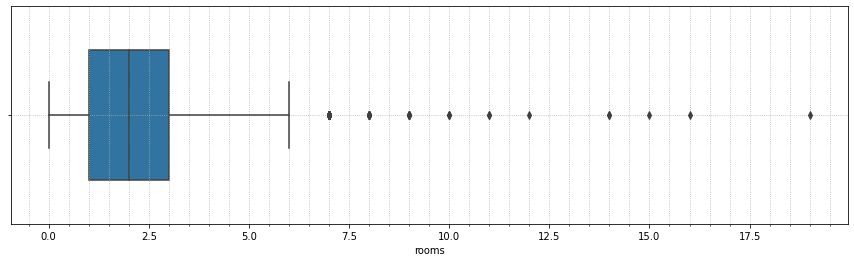

In [47]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.boxplot(data=data, x='rooms', width=0.6)
plt.minorticks_on()
plt.grid(which='both', linestyle = ':')

In [48]:
(data['rooms'].quantile(q=0.75) - data['rooms'].quantile(q=0.25)) * 1.5 + data['rooms'].quantile(q=0.75)

6.0

**Квартиры с комнатами более 6 являются выбросами в данных.**

##### Удалим аномальные значения в столбцах `rooms`, `last_price`, `total_area` (превышающих Q3 + 1.5IQR)

In [49]:
data_clean = data.loc[(data['rooms'] <= 6) & 
                      (data['last_price'] <= 37378804.1) & 
                      (data['total_area'] <= 158.97)].reset_index(drop=True)

In [50]:
data_clean.tail()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,distance_to_center
23007,9,9700000,133.81,2017-03-21,3,3.7,5,73.300000,3,False,False,False,13.83,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,Город
23008,14,3100000,59.00,2018-01-15,3,2.6,5,38.000000,4,False,False,False,8.50,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,None
23009,18,2500000,56.70,2018-02-11,2,2.6,3,29.700000,1,False,False,False,9.10,0,Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
23010,13,11475000,76.75,2017-03-28,2,3.0,17,44.278846,12,False,False,False,23.30,2,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,Пригород
23011,4,1350000,32.30,2017-07-21,1,2.5,5,12.300000,1,False,False,False,9.00,0,Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


##### Устранение аномальных значений в столбце `ceiling_height`
Посчитаем количество квартир с высотой потолка выше 5 м или ниже 2.3 м

In [51]:
data_clean.query('ceiling_height > 5 or ceiling_height < 2.3').count()['ceiling_height']

47

Т.к квартир не очень много, предположительно, аномальные даннные появились в связи с ошибками при заполнении. Заменим значения, превышающие 5 м и значения меньше 2.3 на медианную высоту потолка

In [52]:
data_clean.loc[(data_clean['ceiling_height'] > 5) | (data_clean['ceiling_height'] < 2.3), 
         'ceiling_height'] = data_clean['ceiling_height'].median()

In [53]:
# Выведем статистики по столбцам в которых были аномальные данные.
data_clean[['ceiling_height', 'total_area', 'last_price', 'rooms', 'living_area', 'kitchen_area']].describe()

,ceiling_height,total_area,last_price,rooms,living_area,kitchen_area
count,23012.000000,23012.000000,2.301200e+04,23012.000000,23012.000000,23012.000000
mean,2.696368,56.636518,5.618588e+06,2.003042,32.461929,10.041471
std,0.221099,23.255586,3.896718e+06,0.951517,15.521779,4.673355
min,2.300000,12.000000,4.300000e+05,0.000000,2.000000,0.000000
25%,2.600000,40.000000,3.400000e+06,1.000000,18.900000,7.100000
50%,2.600000,51.000000,4.589500e+06,2.000000,30.000000,9.100000
75%,2.750000,67.700000,6.500000e+06,3.000000,41.300000,11.042500
max,5.000000,158.600000,3.727200e+07,6.000000,128.000000,65.000000


##### Выведем общую информацию по датасету, оценим на сколько изменился датасет после преобразований данных

In [54]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23012 entries, 0 to 23011
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23012 non-null  int64         
 1   last_price            23012 non-null  int64         
 2   total_area            23012 non-null  float64       
 3   first_day_exposition  23012 non-null  datetime64[ns]
 4   rooms                 23012 non-null  int64         
 5   ceiling_height        23012 non-null  float64       
 6   floors_total          23012 non-null  int64         
 7   living_area           23012 non-null  float64       
 8   floor                 23012 non-null  int64         
 9   apartment             23012 non-null  bool          
 10  studio                23012 non-null  bool          
 11  open_plan             23012 non-null  bool          
 12  kitchen_area          23012 non-null  float64       
 13  balcony         

In [55]:
# Оценим на сколько процентов у нас стало меньше данных.
100 - (len(data_clean) / 23699 * 100)

2.8988564918351045

**Наш датасет уменьшился на 2.9%**

**В ходе предобработки данных были:**
1. Изменены названия в столбцах: `cityCenters_nearest, `parks_around3000`, `ponds_around3000`, `is_apartment` для приведения их к общему стилю названий столбцов.
2. Определены и заполнены пропуски данных. Пропущенные данные в столбцах `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, `days_exposition` было решено не устранять и оставить как есть, т.к. не получится корректно восстановить, также мы не можем удалить столь большой объем данных из датасета.
3. Заполнены пропуски в стобцах `balcony`, `apartment`, `ceiling_height`, `living_area`, `kitchen_area`,  ``
4. Удалены пропуски в столбцах `floors_total` и `locality_name`
5. Изменены тип данных в столбцах `last_price`, `floors_total`, `first_day_exposition`
6. Удалены неявные дубликаты в столбце `locality_name`
7. Устранены аномальные значения в столбцах `ceiling_height`,  `last_price`, `total_area`, `rooms`.

Пропуски, вероятнее всего, возникли при составлении объявления.К примеру, если небыло балкона в квартире, составитель не указывал значение 0, и в результате этого появлялся пропуск в данных, для решения данной проблемы можно сделать заполнение этих строк обязательным.

Пропуски в столбцах, связанных с картографическими данными могли возникнуть в связи с незаполнением адреса квартиры, чтобы минимизировать это можно также сделать обязательным заполнение адреса (до номера дома или хотябы до станции метро).

Неявные дубликаты в данных можно уменьшить с внедрением автоматического присвоения названия города по картографическим данным, и страндартизировать названия населенных пунктов.

После удаления аномалий в данных наш датасет сократился на 2.9%, что приемлемо

### Посчитайте и добавьте в таблицу новые столбцы

Добавим столбцы с ценой 1 кв.м, столбцы с днями недели, месяца и года публикации объявления, добавим столбец с типом этажа картиры и добавим столбец с расстоянием до цента города в км.

#### Добавим столбец с ценой одного квадратного метра 

In [56]:
data_clean['price_of_meter'] = data_clean['last_price'] / data_clean['total_area']
# Посмотрим статистики в тысячах рублей за квадратный метр
data_clean['price_of_meter'].describe() / 1000

count     23.012000
mean      96.668896
std       37.296336
min        7.962963
25%       76.174733
50%       94.565217
75%      113.244398
max      848.484848
Name: price_of_meter, dtype: float64

#### Добавим столбцы с днями недели, месяца и года публикации 

In [57]:
# Создадим новый столбец weekday_of_publishing и заполним днями недели публикации объявления 
# 0 - понедельник, 6 - воскресенье
data_clean['weekday_of_publishing'] = data_clean['first_day_exposition'].dt.weekday

# Создадим новый столбец month_of_publishing и заполним номерами месяцев публикации объявления 
data_clean['month_of_publishing'] = data_clean['first_day_exposition'].dt.month

# Создадим новый столбец year_of_publishing и заполним годами публикации объявления 
data_clean['year_of_publishing'] = data_clean['first_day_exposition'].dt.year

In [58]:
# Выведем 4 столбца для проверки корректного заполнения столбцов
data_clean[['first_day_exposition', 'weekday_of_publishing', 'month_of_publishing', 'year_of_publishing']].head()

,first_day_exposition,weekday_of_publishing,month_of_publishing,year_of_publishing
0,2019-03-07,3,3,2019
1,2018-12-04,1,12,2018
2,2015-08-20,3,8,2015
3,2018-06-19,1,6,2018
4,2018-09-10,0,9,2018


#### Добавим в таблицу тип этажа кваритиры
Добавим в таблицу столбец `floor_category` со значениями:
- квартира на 1 этаже - Первый;
- квартира на последнем этаже - Последний;
- квартира ни на первом ни на последнем этаже - Другой.

In [59]:
data_clean['floor_category'] = 'Другой'
data_clean.loc[data_clean['floor'] == data_clean['floors_total'], 'floor_category'] = 'Последний'
data_clean.loc[data_clean['floor'] == 1, 'floor_category'] = 'Первый'

#### Перевод расстояния до центра города из м в км

In [60]:
# Создадим новый столбец city_centers_nearest_km, значения столбца city_centers_nearest разделим на 1000 (для удобства)
data_clean['city_centers_nearest_km'] = (data_clean['city_centers_nearest'] // 1000)

In [61]:
# Проверим правильно ли создались ли столбцы
data_clean[['floor', 'floor_category', 'city_centers_nearest' , 'city_centers_nearest_km']].head()

,floor,floor_category,city_centers_nearest,city_centers_nearest_km
0,8,Другой,16028.0,16.0
1,1,Первый,18603.0,18.0
2,4,Другой,13933.0,13.0
3,13,Другой,8098.0,8.0
4,5,Другой,NaN,NaN


**Были добавлены следующие столбцы:**
- `price_of_meter` - цена за 1 кв.м 
- `weekday_of_publishing` - день недели публикации объявления
- `month_of_publishing` - месяц публикации объявления
- `year_of_publishing` - год публикации объявления
- ‘floor_category’ - тип этажа квартиры (Первый, Последний, Другой)
- 'city_centers_nearest_km' - расстояние до центра города в км и округлено до целых значений

### Проведите исследовательский анализ данных

В ходе исследовательского анализа данных рассмотрим распределения значений по столбцам и определим их статистики. Это необходимо для визуального представления данных.
Найдем взаимосвязи в данных и особенности в распределениях значений.
Определим какие факторы влияют на цену недвижимости.

#### Анализ значений столбца `total_area`

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

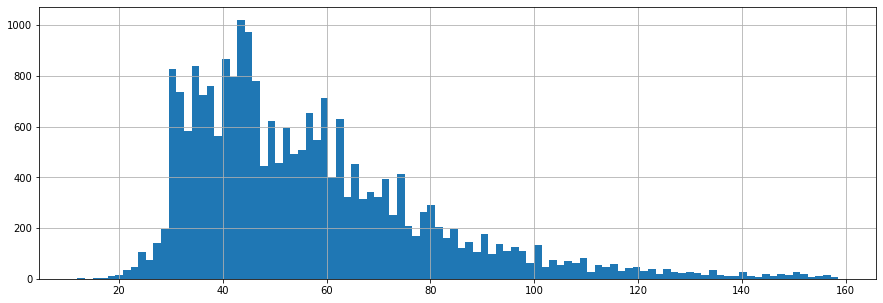

In [62]:
# Посмотрим на статистики столбца total_area
display(data['total_area'].describe())
# Отобразим гистограмму 
data_clean['total_area'].hist(bins=100, figsize=(15, 5));

Судя по гистограмме наиболее встречаемая площадь квартир в диапазоне 30 - 80 кв.м

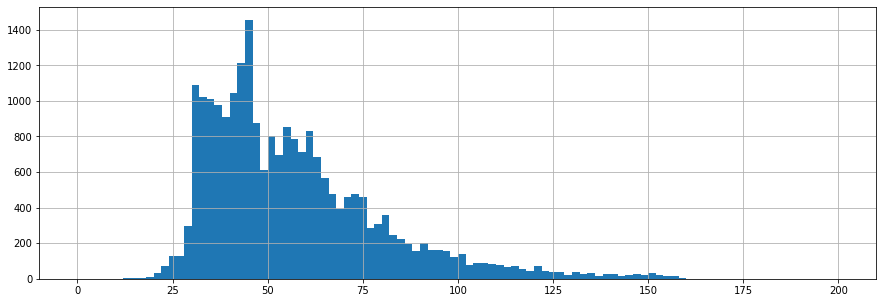

In [63]:
# Рассмотрим гистограмму для квартир с площадью меньше 200 кв.м.
data_clean['total_area'].hist(bins=100, figsize=(15, 5), range=(0,200));

При более детальном рассмотрении мы видим, что выделяются несколько интервалов площадей.
30 кв.м, 45 кв.м, 50-55 кв.м, 70-75 кв.м. Предположу, что это связано с типовыми планировками квартир, 30 кв.м - однокомнатная квартира, 45 кв.м двухкомнатная и т.д.

Для проверки этого предположения выведем сводную таблицу по количеству комнат и площади квартиры.

In [64]:
data_clean.pivot_table(index='rooms', values='total_area', aggfunc=('mean', 'median', 'count')).head(5)

,count,mean,median
rooms,,,
0,193,27.551347,26.05
1,8000,37.547703,36.56
2,7879,55.655248,53.00
3,5679,76.057096,72.20
4,1038,96.420308,95.00


Как видно из сводной таблицы таблицы медианные и средние значения в целом не сильно разнятся, можно сделать вывод, что сводная таблица отображает стандартные планировки наиболее встречаемых квартир. Мое предположение было немного не верным.

Создадим график для отображения распределения площади квартир в зависимости от количества комнат.

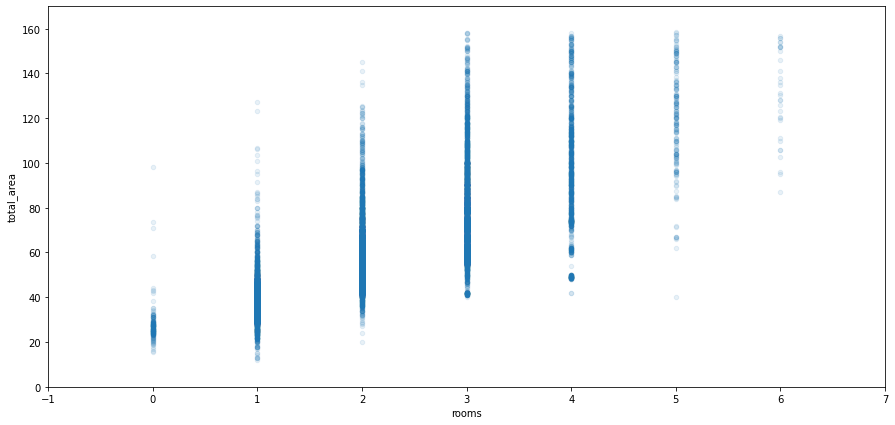

In [65]:
data_clean.plot(kind='scatter', x='rooms', y='total_area', figsize=(15, 7), xlim=(-1, 7), ylim=(0, 170), alpha=0.1);

#### Анализ значений столбца `kitchen_area`

count    23012.000000
mean        10.041471
std          4.673355
min          0.000000
25%          7.100000
50%          9.100000
75%         11.042500
max         65.000000
Name: kitchen_area, dtype: float64

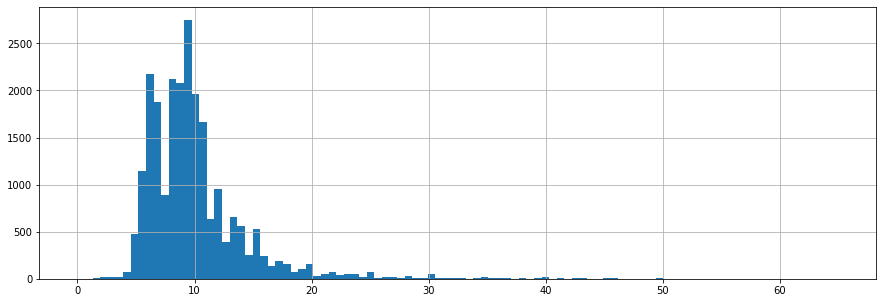

In [66]:
# Отобразим статистики по столбцу kitchen_area
display(data_clean['kitchen_area'].describe())
# Отобразим гистограмму
data_clean['kitchen_area'].hist(bins=100, figsize=(15, 5));

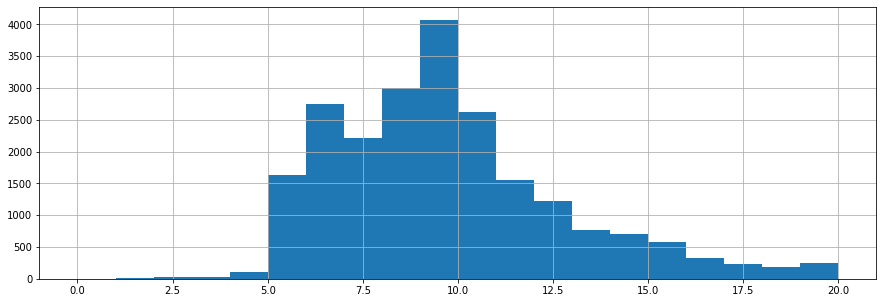

In [67]:
# Посмотрим поближе на наиболее встечающиеся площади кухонь
data_clean['kitchen_area'].hist(bins=20, figsize=(15, 5), range=(0, 20));

По гистограмме видно, что наиболее кухни площадь в 6 - 12 кв.м являются наиболее встречаемыми. Ранее на диаграмме распеределения площади кухни и общей площади мы видели, что в основном встречаются кухни площадью 5 - 15 кв.м.

Рассмотрим распределение площади кухни относительно количества комнат в квартире.

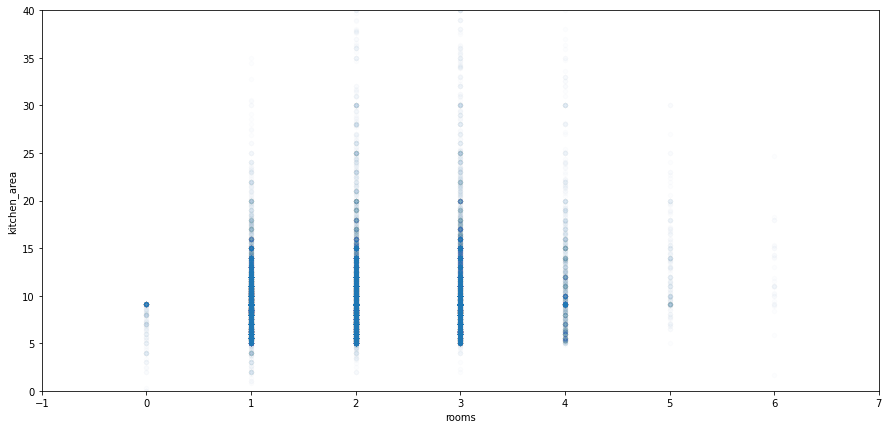

In [68]:
data_clean.plot(kind='scatter', 
                x='rooms', 
                y='kitchen_area', 
                figsize=(15, 7), 
                xlim=(-1, 7), 
                ylim=(0, 40), 
                alpha=0.01);

По диаграмме видно, что площадь кухни, в общей массе, стандартная и не сильно зависит от количества комнат.

Убедимся в этом рассчитав коэффициет корреляции.

In [69]:
data_clean['rooms'].corr(data_clean['kitchen_area'])

0.1561019107471334

Есть **слабая зависимость** между площадью кухни и количеством комнат

#### Анализ значений столбца `living_area`

count    23012.000000
mean        32.461929
std         15.521779
min          2.000000
25%         18.900000
50%         30.000000
75%         41.300000
max        128.000000
Name: living_area, dtype: float64

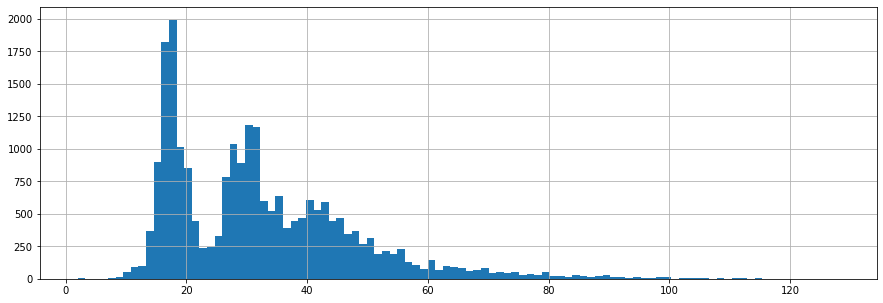

In [70]:
# Отобразим статистики по столбцу living_area
display(data_clean['living_area'].describe())
# Отобразим гистограмму
data_clean['living_area'].hist(bins=100, figsize=(15, 5));

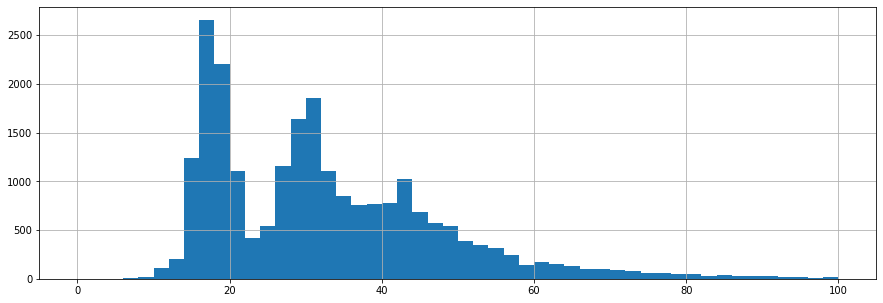

In [71]:
# Посмотрим поближе на наиболее встечающиеся значения жилой площади.
data_clean['living_area'].hist(bins=50, figsize=(15, 5), range=(0, 100));

Из распределения видно 3 моды (наиболее встречающиеся значения), предположительно:
- 16-20 кв.м для однокомнатных квартир
- 28-32 кв.м для двухкомнатных квартир
- 42-45 кв.м для трехкомнатных квартир

Построим график распределения жилой площади от количества комнат.

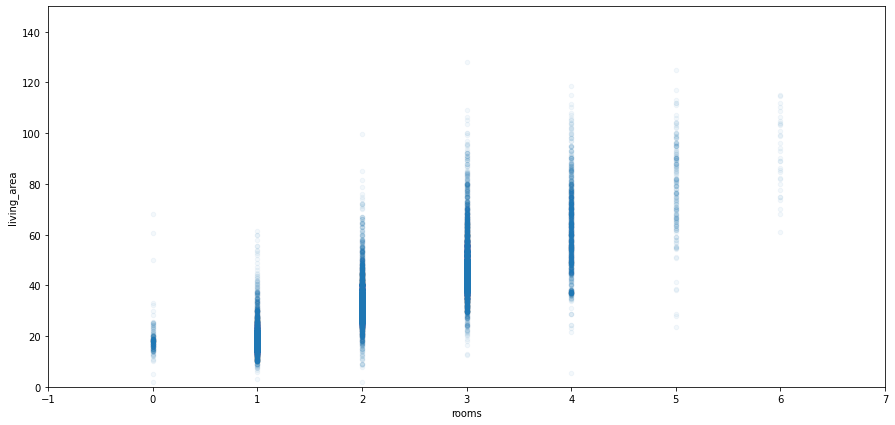

In [72]:
data_clean.plot(kind='scatter', 
                x='rooms', 
                y='living_area', 
                figsize=(15, 7), 
                xlim=(-1, 7), 
                ylim=(0, 150), 
                alpha=0.05);

Предположение о модальных значениях подтверждается, видно, что есть связь между жилой площадью и количеством комнат

#### Анализ значений столбца `rooms`

count    23012.000000
mean         2.003042
std          0.951517
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

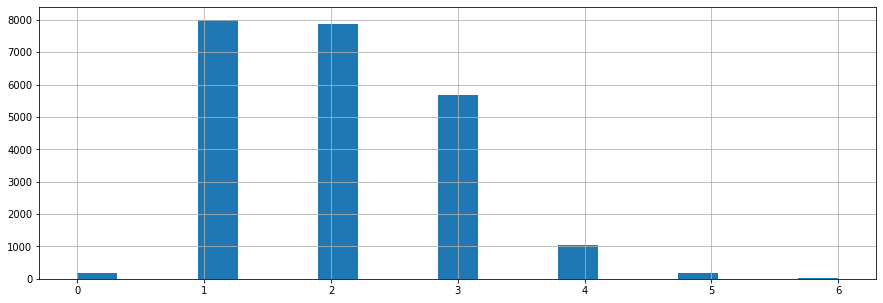

In [73]:
# Отобразим статистики по столбцу living_area
display(data_clean['rooms'].describe())
# Отобразим гистограмму
data_clean['rooms'].hist(bins=19, figsize=(15, 5));

Из гистограммы видно, что наиболее продоваемыми квартирами являются однокомнатные квартиры и двухкомнатные квартиры, трехкомнатные квартиры продаются немного реже, гораздо меньше продается 4-х и более комнатные квартиры.

#### Анализ значений столбца `ceiling_height`

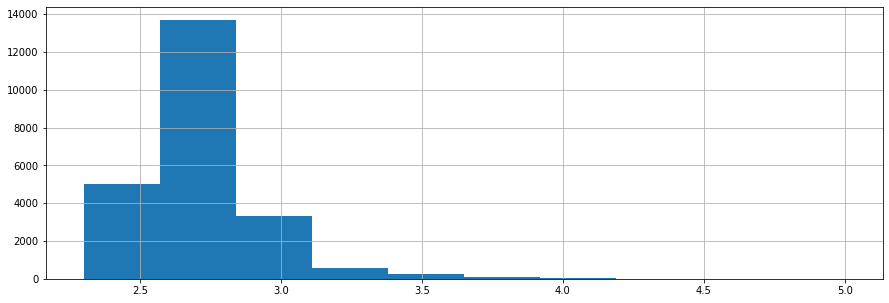

In [74]:
# Отобразим гистограмму
data_clean['ceiling_height'].hist(bins=10, figsize=(15, 5));

Наиболее встречающиеся значения высоты потолка: 2.5, 2.6 и 3 м.
Ранее было выявлено, что наиболее высокие потолки в квартирах, находящихся рядом с центром Санкт-Петербурга, с отдалением от цента высота потолка снижается.

#### Анализ значений столбца `floor` , `floors_total` и `floor_category`

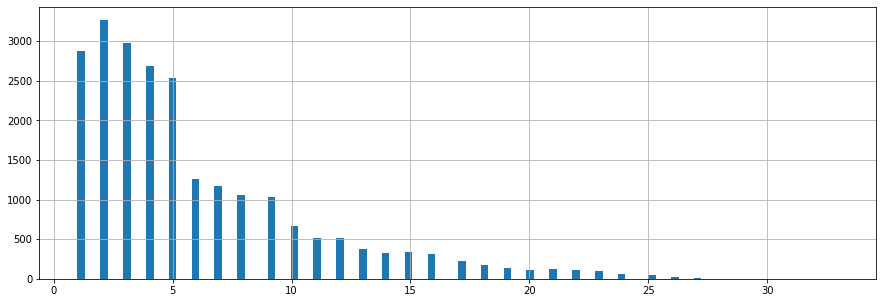

In [75]:
# Отобразим гистограмму по столбцу floor 
data_clean['floor'].hist(bins=100, figsize=(15, 5));

Судя по гистограмме наибольшее количество квартир продается в с 1 по 5 этажи, далее идут квартиры с 6 по 9 этаж и т.д, предпологаю, что это связано с этажностью зданий, чтобы это проверить построим гистограмму по этажности зданий

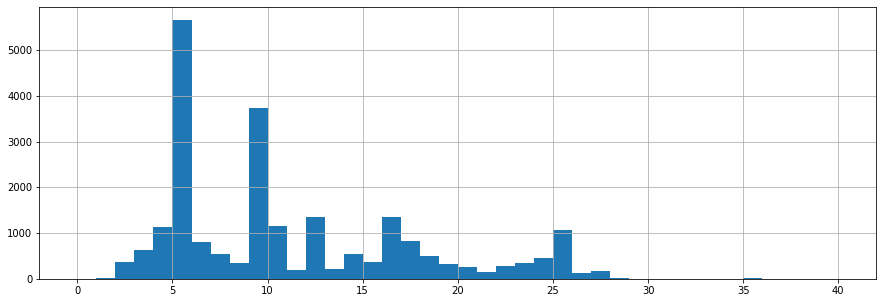

In [76]:
data_clean['floors_total'].hist(bins=40, figsize=(15, 5), range=(0, 40));

Как видно по гистограмме столбца `floors_total` действительно преобладают дома этажностью 5, 9, 12, 16 и 25 этажей.

Проверим изменяется ли этажность с удалением от центра города.

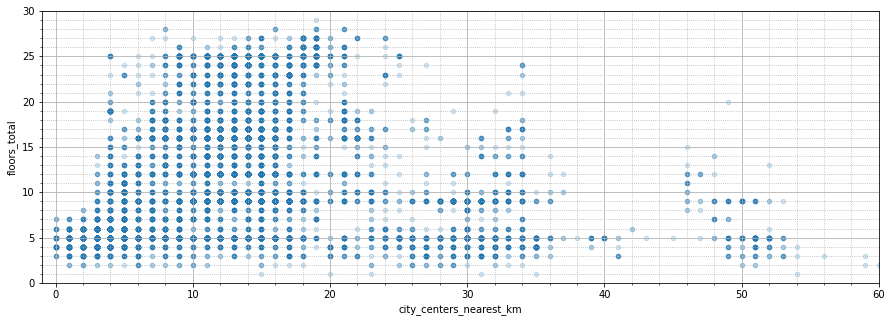

In [77]:
data_clean.plot(kind='scatter', x='city_centers_nearest_km', y='floors_total', 
          figsize=(15, 5), alpha=0.2, xlim=(-1, 60), ylim=(0, 30), grid=True)

plt.minorticks_on()
plt.grid(which='minor', linestyle = ':');

По графику видно, что центре города (до 3-х км от центра) преимущественно низкоэтажная застройка до 7 этажей. На расстоянии 3 - 24 км дома различной этажности (до 30 этажей). На расстоянии большем 24 км от центра города этажность зданий резко снижается.

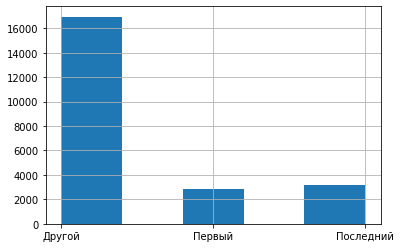

In [78]:
# Построим гистограмму по значениям столбца floor_category
data_clean['floor_category'].hist(bins=5);

Наибольшее количество квартир продаются на средних этажах, что вполне логично. Меньше всего продают квартир на 1 этаже, скорее всего это связано с тем, что на первом этаже помещения используют как коммерческую недвижимость.

#### Анализ значений столбца `city_center_nearest_km`

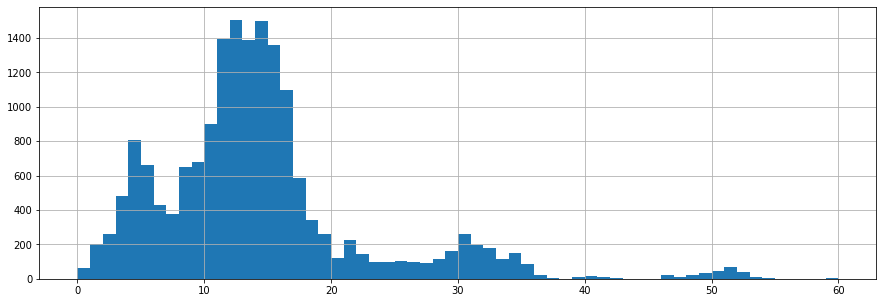

In [79]:
# Выведем гистограмму по значением столбца city_centers_nearest_km
data_clean['city_centers_nearest_km'].hist(bins=60, range=(0, 60), figsize=(15, 5));

Из диаграммы видно, что самое большее количество квартир продается на расстоянии 10 - 16 км от цента города (в г.Санкт-Петербург), далее резко снижается количество объявлений, скорее всего, это связано с уменьшением плотности застройки. На 30 и 51 км от центра видим локальное увеличение количества объявлений, предполагаю, что на этом удалении находятся города.

#### Анализ значений столбца `airports_nearest`

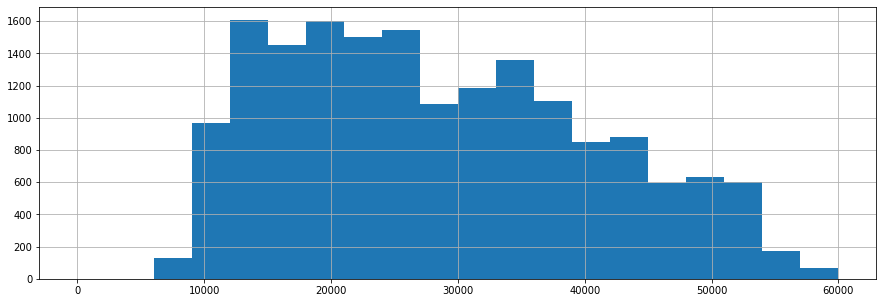

In [80]:
data_clean['airports_nearest'].hist(figsize=(15, 5), bins=20, range=(0, 60000));

Из диаграммы видно, что на расстоянии до 6-7 км от аэропорта квартиры не продаются, большинство квартир находятся на расстоянии от 10 до 40 км от аэропорта.

#### Анализ значений столбца `parks_nearest`

count    7659.000000
mean      493.924533
std       342.070906
min         1.000000
25%       289.000000
50%       456.000000
75%       614.000000
max      3190.000000
Name: parks_nearest, dtype: float64

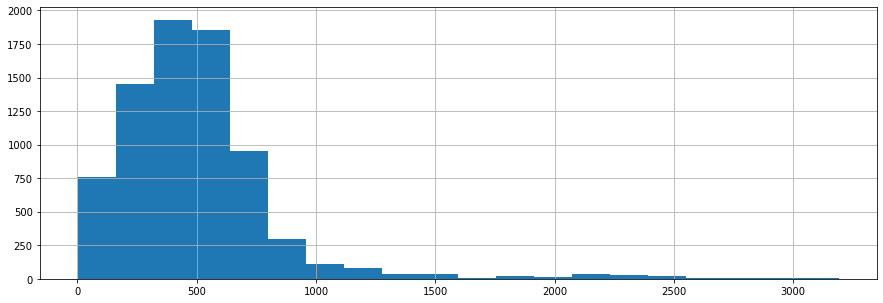

In [81]:
# Отобразим статистики по столбцу parks_nearest
display(data_clean['parks_nearest'].describe())
# Отобразим гистограмму
data_clean['parks_nearest'].hist(bins=20, figsize=(15, 5));

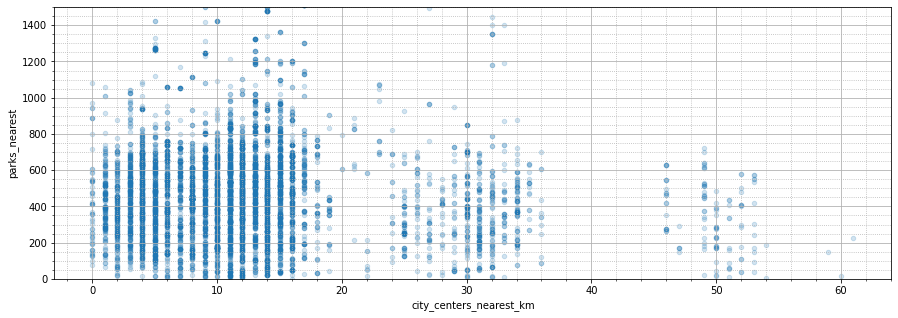

In [82]:
# Отобразим график, чтобы посмотреть как изменяется расстояник от ближайшего парка при удалении от центра города
data_clean.plot(y='parks_nearest', x='city_centers_nearest_km', kind='scatter', 
          figsize=(15, 5), alpha=0.2, ylim=(0, 1500), grid=True)

plt.minorticks_on()
plt.grid(which='minor', linestyle = ':');

Из графика видно, что в г. Санкт-Петербург (до 20 км от центра), с среднем, расстояние до ближайшего парка составляет около 400 м. В интервалах 20 - 24 км и 36 - 46 км парки практически отсутствуют, скорее всего это населенные пункты в большей части представленные частным сектором с загородными домами

#### Анализ значений столбцов `weekday_of_publishing` и `month_of_publishing`

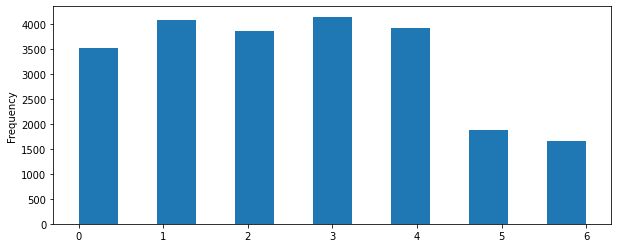

In [83]:
# Построим гистограмму по распределению объявлений по дням недели
data_clean['weekday_of_publishing'].plot(kind='hist', bins=13, figsize=(10, 4));

Из диаграммы видно, что в выходные дни гораздо меньше публикуется объявлений, скорее всего это связано с тем, что у риелторов выходной и они не публикуют объявления.

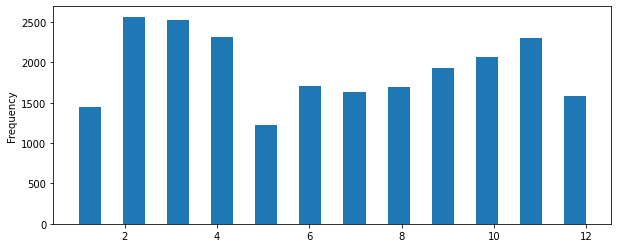

In [84]:
# Построим гистограмму распределения количества объявлений по месяцам
data_clean['month_of_publishing'].plot(kind='hist', bins=23, figsize=(10, 4));

В январе и мае наименьшее количество объявлений, скорее всего это связано так же с выходными днями, риелторы не работают и не публикуют объявления, к лету количество объявлений уменьшается, а зиме увеличивается.

#### Анализ значений столбца `last_price`

count    2.301200e+04
mean     5.618588e+06
std      3.896718e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.589500e+06
75%      6.500000e+06
max      3.727200e+07
Name: last_price, dtype: float64

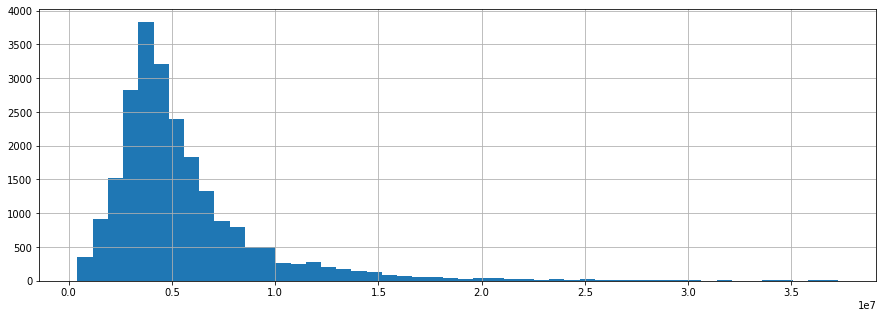

In [85]:
# Посмотрим статистики по столбцу last_price
display(data_clean['last_price'].describe())
# Отобразим гисторграмму
data_clean['last_price'].hist(figsize=(15, 5), bins=50);

Из гисторгаммы видно, что наиболее встечающаяся цена на рынке жилья до 10 млн.руб, длинный правый хвост распределения из-за того, что в выборке есть жилье дороже 35 млн.руб

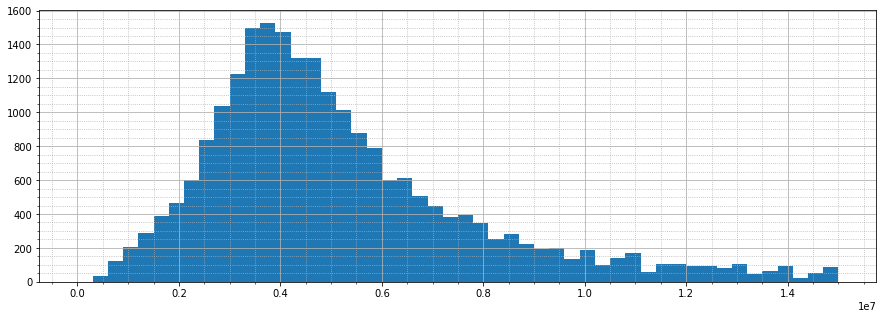

In [86]:
# Отобразим гистограмму с ценами до 15 млн.руб
data_clean['last_price'].hist(figsize=(15, 5), bins=50, range=(0, 15_000_000))
plt.minorticks_on()
plt.grid(which='minor', linestyle = ':');

Как видно из гистограммы, наиболее встечающиеся цены на квартиры в диапазоне 3 - 5 млн.руб.

#### Анализ значений столбца `price_of_meter`

count     23012.000000
mean      96668.895584
std       37296.335583
min        7962.962963
25%       76174.733031
50%       94565.217391
75%      113244.398244
max      848484.848485
Name: price_of_meter, dtype: float64

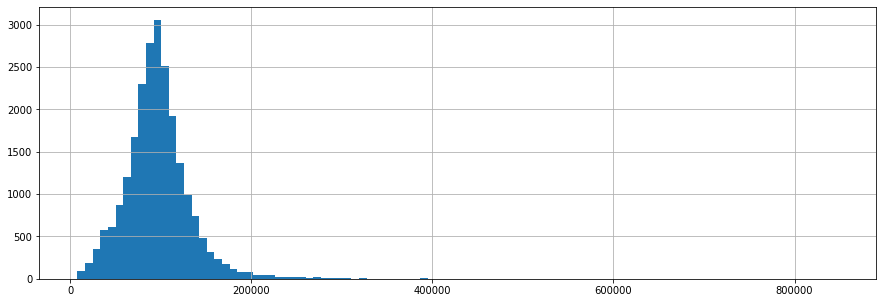

In [87]:
# Посмотрим статистики по столбцу price of meter
display(data_clean['price_of_meter'].describe())
# Построим гистограмму по распредлению цен за 1 кв.м.
data_clean['price_of_meter'].hist(bins=100, figsize=(15, 5));

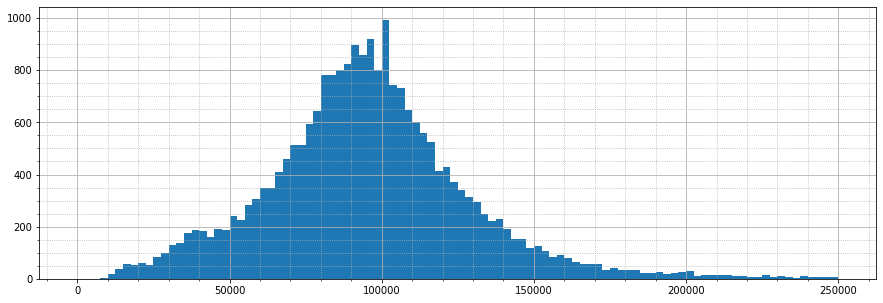

In [88]:
# Рассмотрим наиболее встречающуюся цену за 1 кв.м.
data_clean['price_of_meter'].hist(bins=100, figsize=(15, 5), range=(0, 250_000))
plt.minorticks_on()
plt.grid(which='minor', linestyle=':');

По гистограмме видно, что больше всего квартир с ценой за 1 кв.м в районе 80 - 100 тыс./кв.м. Медианная цена составляет 95 тыс.руб, средняя 99.4 тыс.руб, средняя чуть выше так-как среднее чувствительно к аномально большим или аномально малым значениям. 

Посмотрим как влияет количество комнат в квартире на стоимость 1 кв.м. Отобразим до 9 комнатных квартир.

In [89]:
data_clean.pivot_table(index='rooms', values=['price_of_meter'], aggfunc=['median']).head(10)

,median
,price_of_meter
rooms,
0,105098.039216
1,100000.000000
2,92727.272727
3,88571.428571
4,89559.494196
5,87804.878049
6,87555.684642


Как видно из сводной таблицы, с увеличение количества комнат средняя цена за 1 кв.м снижается до от студий к 3-х комнатным квартирам, далее начинается рост средней стоимости квартиры, скорее всего рост стоимости 1 кв.м связан, с тем что квартиры с большим количеством комнат относятся к другому классу жилья.

#### Изучим как быстро продовались квартиры

In [90]:
data_clean['days_exposition'].describe()

count    19989.000000
mean       178.416979
std        217.441647
min          1.000000
25%         44.000000
50%         94.000000
75%        227.000000
max       1580.000000
Name: days_exposition, dtype: float64

Судя по статистикам максимальный срок продажи квартиры 1580 дней, минимальный - 1 день, что ,в принципе, может быть.

**Средний срок продажи квартиры составляет 180 дней, медианное значение равно 95 дням.**

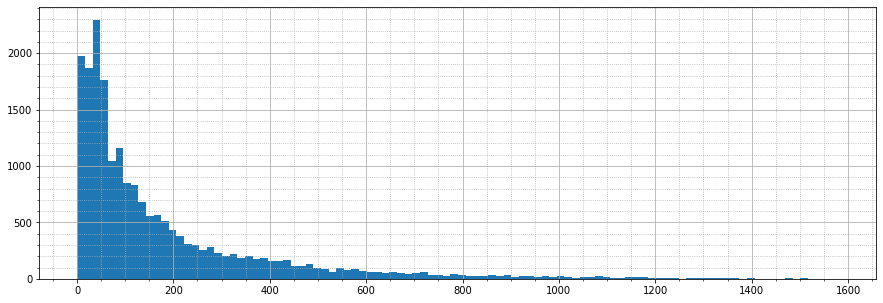

In [91]:
# Построим график продаж квартир
data_clean['days_exposition'].hist(figsize=(15, 5), bins=100)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')

На гистограмме выделяются несоклько пиковых значений, посмотрим на гистограмму поближе.

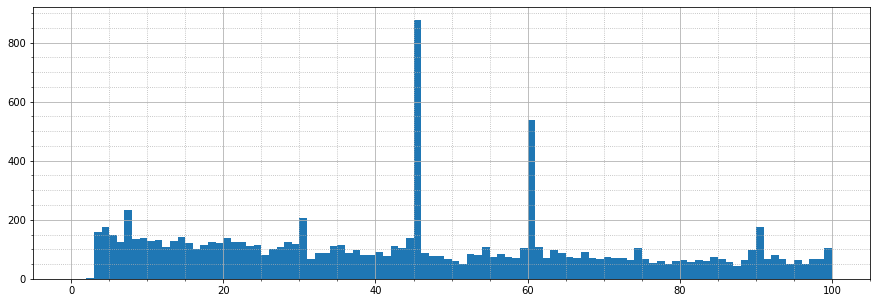

In [92]:
data_clean['days_exposition'].hist(figsize=(15, 5), bins=100, range=(0, 100))
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')

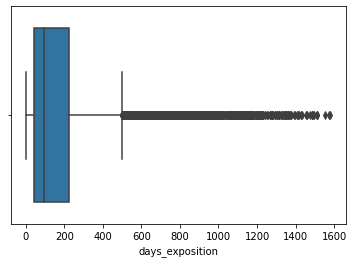

In [93]:
sns.boxplot(data=data_clean, x='days_exposition');

По гистограмме видно, что есть пики значений на 7, 30, 45, 60 и 90 днях, скорее всего это связано с тем, что объявления автоматически закрываются в эти дни, возможно это как-то связано с тарифами на размещение объявлений.

Большая половина квартир продается в течении 3-х месяцев, 25% в течении 45 дней, что в принципе можно считать за быстрый срок продажи квартиры. Судя по боксплоту необычно долгой продажей сожно считать продажу дольше 500 дней.

#### Анализ факторов, влияющих на цену квартиры

In [94]:
# Создадим датафрейм с необходими данными для анализа факторов влияющих на цену квартиры
df_good = data_clean[['last_price', 'price_of_meter', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'ceiling_height', 
          'balcony', 'floor', 'floors_total', 'city_centers_nearest_km', 'parks_nearest', 'days_exposition', 
           'locality_name', 'weekday_of_publishing', 'month_of_publishing', 'year_of_publishing']]
df_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23012 entries, 0 to 23011
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   last_price               23012 non-null  int64  
 1   price_of_meter           23012 non-null  float64
 2   total_area               23012 non-null  float64
 3   living_area              23012 non-null  float64
 4   kitchen_area             23012 non-null  float64
 5   rooms                    23012 non-null  int64  
 6   ceiling_height           23012 non-null  float64
 7   balcony                  23012 non-null  int64  
 8   floor                    23012 non-null  int64  
 9   floors_total             23012 non-null  int64  
 10  city_centers_nearest_km  17529 non-null  float64
 11  parks_nearest            7659 non-null   float64
 12  days_exposition          19989 non-null  float64
 13  locality_name            23012 non-null  object 
 14  weekday_of_publishing 

<AxesSubplot:>

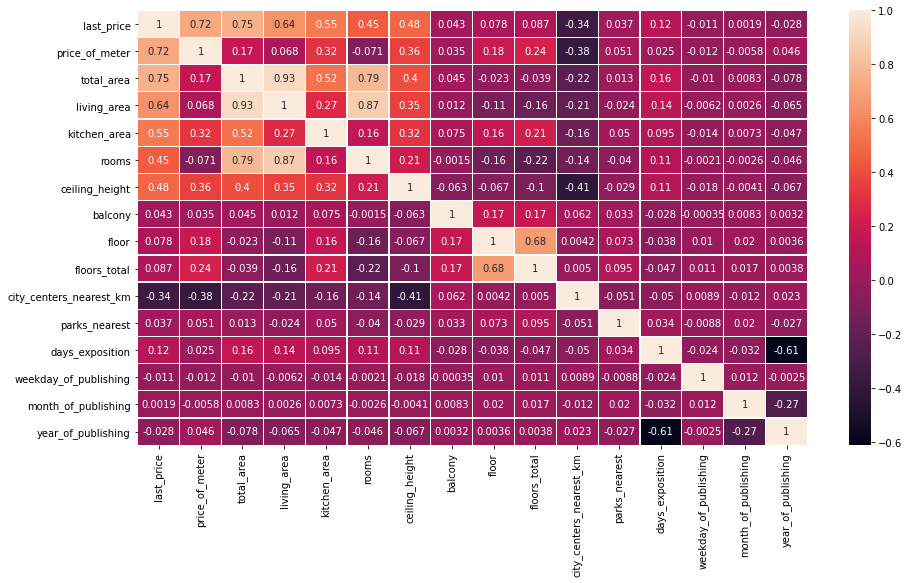

In [95]:
# Построим тепловую карту по таблице корряляции факторов
plt.figure(figsize=(15, 8))
sns.heatmap(df_good.corr(), annot=True, linewidths=.2)

По тепловой карте видим, что есть высокая корреляция столбца `last_price` с `total_area` и `living_area` (которые взаимосвязаны). Более низкая корреляция `last_price` с `kitchen_area`, `rooms`, `ceiling_height` и `city_centers_nearest_km`. В столбце `city_centers_nearest_km` (расстояние от центра города) отрицательная корреляция, т.е. с увеличением расстояния цена снижается. Со столбцами `balcony`, `floor`, `floors_total`, `parks_nearest` и `days_exposition` практически отсутствует.

Для более точного анализа зависимостей вынесем квартиры из Санкт-Петербурга в отдельный датасет.

In [96]:
spb_flats = df_good[df_good['locality_name'] == 'Санкт-Петербург']

#### Посмотрим диаграмму зависимости общей площади и цены квартиры

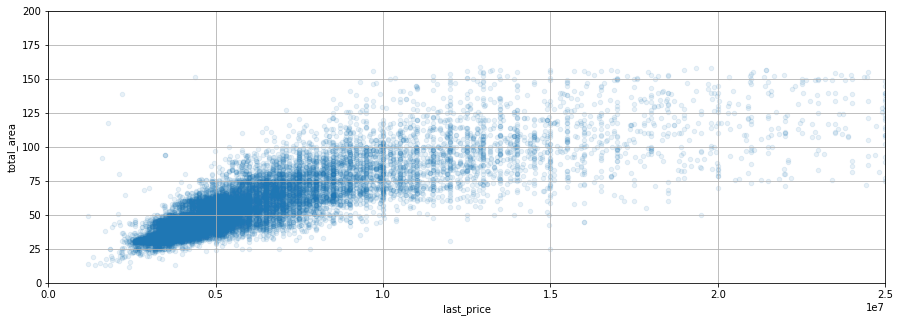

In [97]:
spb_flats.plot(kind='scatter', 
          x='last_price', 
          y='total_area', 
          alpha=0.1, 
          figsize=(15,5), 
          xlim=(0, 25_000_000), 
          ylim=(0, 200), 
          grid=True);

Как и ожидалось мы видим линейную зависимость увеличения стоимости квартиры от общей площади.

#### Оценим как изменяется средняя стоимость 1 кв.м в зависимости от общей площади квартиры.

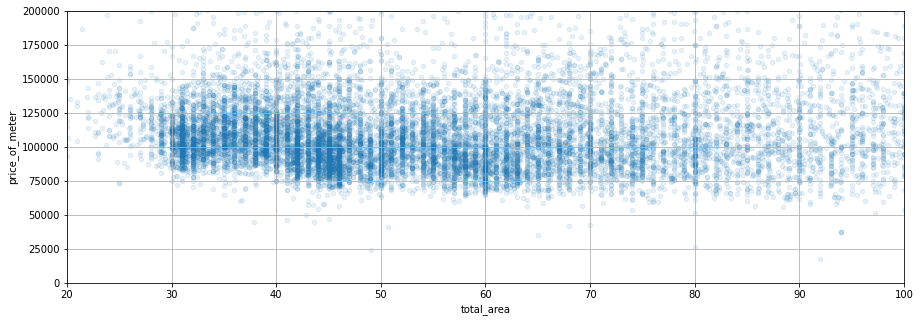

In [98]:
spb_flats.plot(kind='scatter', 
          x='total_area', 
          y='price_of_meter', 
          alpha=0.1, 
          figsize=(15,5), 
          xlim=(20, 100),
          ylim=(0, 200_000), 
          grid=True);

Судя по графику наблюдается тренд на уменьшение средней стоимости квадратного метра с увеличением площади квартиры.

#### Построим диаграмму зависимости жилой площади и цены квартиры

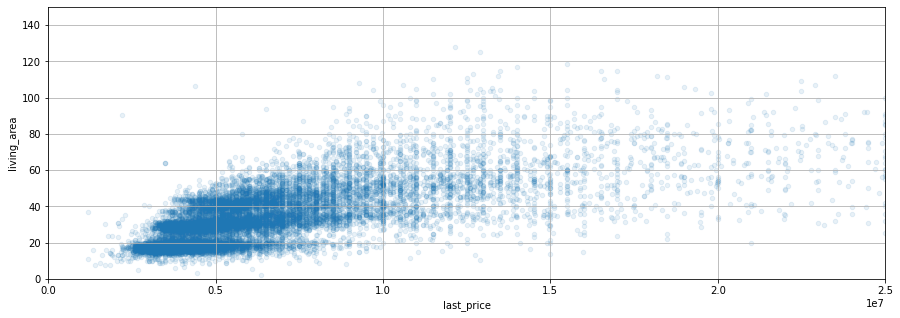

In [99]:
spb_flats.plot(kind='scatter', 
          x='last_price', 
          y='living_area', 
          alpha=0.1, 
          figsize=(15,5), 
          xlim=(0, 25_000_000), 
          ylim=(0, 150), 
          grid=True);

На графике видно, что в общем наблюдается тренд на увеличение стоимости квартиры с увеличением жилой площади, но зависимость не такая явная как в сравнении роста цены жилья от общей площади квартиры.

#### Построим диаграмму зависимости площади кухни и цены квартиры

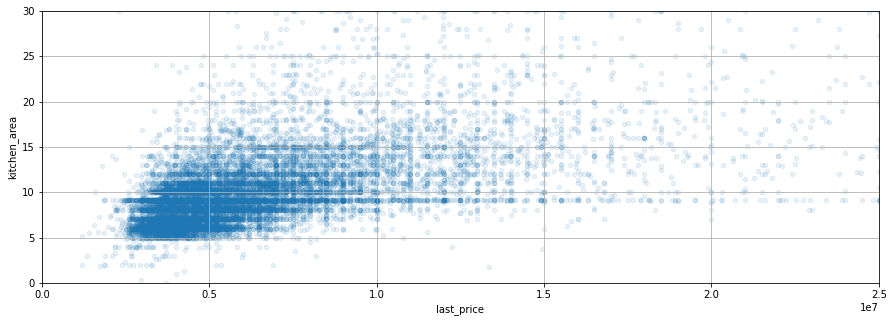

In [100]:
spb_flats.plot(kind='scatter', 
          x='last_price', 
          y='kitchen_area', 
          alpha=0.1, 
          figsize=(15,5), 
          xlim=(0, 25_000_000), 
          ylim=(0, 30),
          grid=True);

На графике видно, что в общем наблюдается тренд на увеличение стоимости квартиры с увеличением кухни, но зависимость не такая явная как в сравнении роста цены жилья от общей площади квартиры, большинство кухонь площадью от 5 до 15 кв.м.

#### Построим диаграмму зависимости количества комнат и цены квартиры

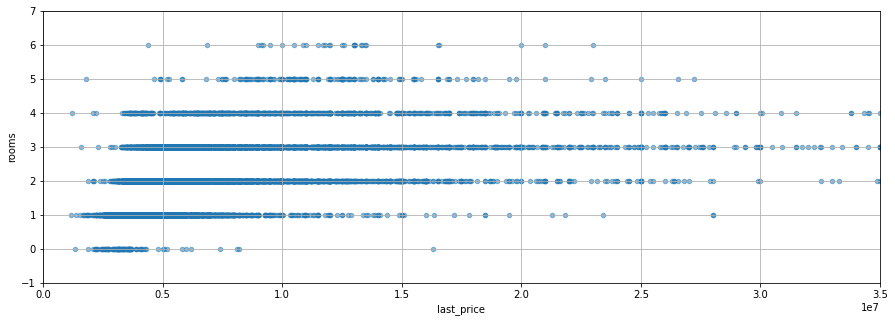

In [101]:
spb_flats.plot(kind='scatter', 
          x='last_price', 
          y='rooms', 
          alpha=0.5, 
          figsize=(15,5), 
          xlim=(0, 35_000_000), 
          ylim=(-1, 7),
          grid=True);

В целом мы видим увеличение стоимости жилья от количества комнат, но это в большей части зависит для минимальной цены на квартиру с определенным количеством комнат. 

#### Зависимость стоимости 1 кв.м от отдаленности от центра и этажа квартиры

Посмотрим как изменяется средеяя цена за 1 кв.м в зависмости от типа этажа и от отдаленности от центра города, для отобразим сводную таблицу по типам этажей.

In [102]:
price_sm_pivot = data_clean.pivot_table(index='floor_category', 
                                  values='price_of_meter', 
                                  columns='distance_to_center', aggfunc='median').round(2)
price_sm_pivot

distance_to_center,Город,Область,Пригород
floor_category,,,
Другой,120938.63,77430.56,100247.52
Первый,103252.25,75489.80,86567.16
Последний,110439.63,78011.03,93253.01


(70000.0, 150000.0)

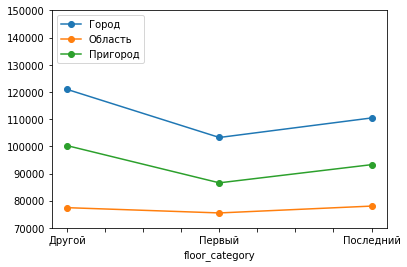

In [103]:
# Отобразим график для наглядности
price_sm_pivot.plot(marker='o', figsize=(6,4))
plt.legend(loc='upper left')
plt.ylim(70_000, 150_000)

Как видно из графика, квартиры на первом этаже самые дешевые, в категории город и пригород самыми дорогими являются квартиры на средних этажах, в области самые дорогие квартиры на последних этажах.

#### Зависимость стоимости квартиры от даты размещения объявления.

In [104]:
# Построим сводную таблицу медианной стоимости квартир в целом и цены кв.м по дням недели
weekday_price = df_good.pivot_table(index='weekday_of_publishing', 
                                      values=['last_price', 'price_of_meter'], 
                                      aggfunc='median')

weekday_price

,last_price,price_of_meter
weekday_of_publishing,,
0,4600000,94257.584323
1,4662500,95230.987918
2,4600000,95195.729537
3,4550000,94668.252782
4,4500000,94262.295082
5,4500000,92948.717949
6,4500000,94244.589928


In [105]:
# Построим сводную таблицу медианной стоимости квартир в целом и цены кв.м по месяцам
month_price = df_good.pivot_table(index='month_of_publishing', 
                                    values=['last_price', 'price_of_meter'], 
                                    aggfunc='median')
month_price

,last_price,price_of_meter
month_of_publishing,,
1,4550000,94936.708861
2,4600000,94666.666667
3,4595000,94936.708861
4,4750000,96144.230769
5,4500000,92307.692308
6,4350000,92440.476190
7,4550000,94444.444444
8,4500000,95801.093067
9,4650000,95296.944159


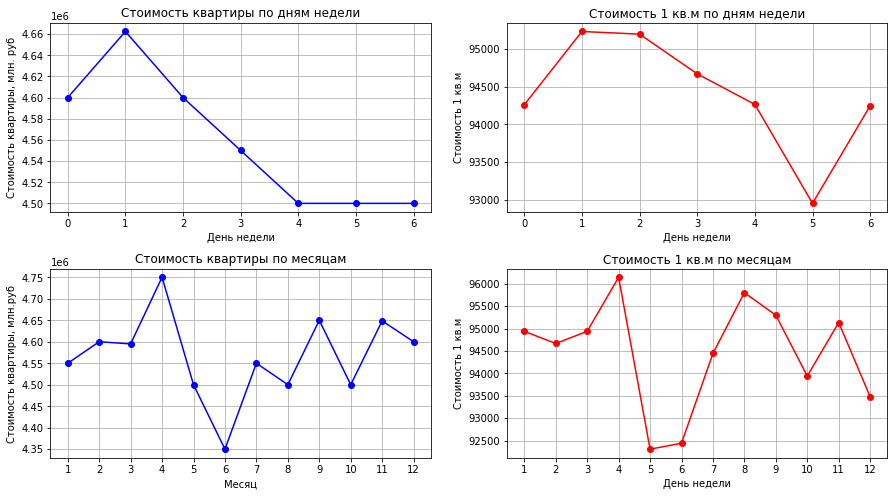

In [106]:
# Отобразим все на графиках
fig, ax = plt.subplots(2, 2, figsize = (15, 8))
ax[0][0].plot(weekday_price.index, weekday_price['last_price'], 'o-b')
ax[0][0].grid()
ax[0][0].set(xlabel='День недели', ylabel='Стоимость квартиры, млн. руб', 
          title='Cтоимость квартиры по дням недели')

ax[0][1].plot(weekday_price.index, weekday_price['price_of_meter'], 'o-r')
ax[0][1].grid()
ax[0][1].set(xlabel='День недели', ylabel='Стоимость 1 кв.м', 
          title='Cтоимость 1 кв.м по дням недели')


ax[1][0].plot(month_price.index, month_price['last_price'], 'o-b')
ax[1][0].grid()
ax[1][0].set(xticks=month_price.index, xlabel='Месяц', ylabel='Стоимость квартиры, млн.руб', 
          title='Cтоимость квартиры по месяцам')

ax[1][1].plot(month_price.index, month_price['price_of_meter'], 'o-r')
ax[1][1].grid()
ax[1][1].set(xticks=month_price.index, xlabel='День недели', ylabel='Стоимость 1 кв.м', 
          title='Стоимость 1 кв.м по месяцам')

plt.subplots_adjust(wspace = 0.2, hspace = 0.3) 


plt.show()

**График по дням недели.**
1. Из графика стоимости квартиры видим, что рост цены квартиры происходит с воскресенья по вторник, со вторника по воскресенье стоимость квартиры падает.
2. Из графика стоимости 1 кв.м мы видим, что с субботы по вторник цена растет, и с субботы по по вторник цена падает.

**График по месяцам**
1. Из графика стоимости квартиры видим, что с января по апрель цена квартиры растет, далее идет резкое падение стоимости квартиры до июня, с июня до конца года мы видим, что цена на квартиры начинает рости.
2. Из графика стоимости 1 кв.м с января по апрель цена растет, резко снижается в мае и далее растет до августа месяца, после виден тренд на уменьшение цены до конца года.

In [107]:
# Построим сводную таблицу медианной стоимости квартир в целом и цены кв.м по годам
year_price = df_good.pivot_table(index='year_of_publishing', 
                                    values=['last_price', 'price_of_meter'], 
                                    aggfunc='median')
year_price

,last_price,price_of_meter
year_of_publishing,,
2014,7182500,104851.674641
2015,5147000,92063.492063
2016,4450000,91250.000000
2017,4450000,92073.956443
2018,4500000,95542.852536
2019,5000000,103000.000000


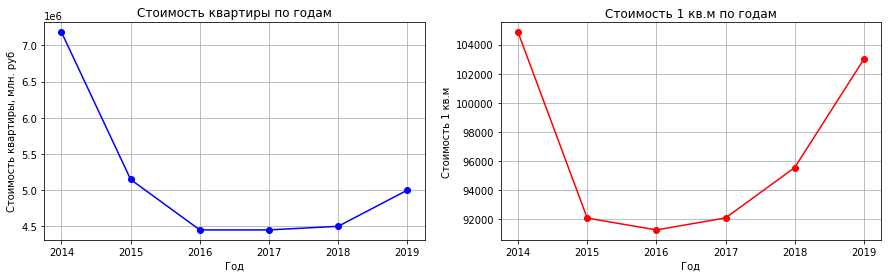

In [108]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].plot(year_price.index, year_price['last_price'], 'o-b')
ax[0].grid()
ax[0].set(xlabel='Год', ylabel='Стоимость квартиры, млн. руб', title='Cтоимость квартиры по годам')

ax[1].plot(year_price.index, year_price['price_of_meter'], 'o-r')
ax[1].grid()
ax[1].set(xlabel='Год', ylabel='Стоимость 1 кв.м', title='Cтоимость 1 кв.м по годам')

plt.show()


По графику цены за квартиру по годам видно, что самая высокая цена была в 2014 году, далее идет спад цены за квартиру. Самая низкая цена была в 2017 году (4.5 млн.руб), после 2017 года начался рост цен на недвижимость.

По графику цена за 1 кв.м примерно такая же ситуация, но самая низкая стоимость зафиксирована в 2016 году (около 92 тыс.руб).

Возможно это связано с кризисом в 2014 году и снижением курса рубля по отношению к доллару, уменьшился спрос на недвижимость и это отразилось на снижении цены.

#### Анализ стоимости самых дорогих населенных пунктов по цене за 1 кв.м с наибольшими объявлениями. 

Создадим сводную таблицу населенным пунктам с самым большим количеством объявлений и выведем медианную цену 1 кв.м в этих населенных пунктах

In [109]:
price_sm_by_location = df_good.pivot_table(index='locality_name', 
                    values='price_of_meter',
                    aggfunc=('count', 'median'))

# Отсортируем по убыванию цены за 1 кв.м
price_sm_by_location.sort_values(by='count', ascending=False).head(10).sort_values(by='median', ascending=False)


,count,median
locality_name,,
Санкт-Петербург,15129,104328.358209
Пушкин,361,99987.179487
Кудрово,470,95555.311677
Парголово,326,91780.224134
Мурино,586,86250.377687
Шушары,439,76829.268293
Колпино,337,74722.222222
Гатчина,307,67796.610169
Всеволожск,398,65789.473684


In [110]:
price_sm_by_location.sort_values(by='median', ascending=True).head(10)

,count,median
locality_name,,
Старополье,3,11000.000000
Свирь,2,11481.481481
Вахнова Кара,1,11688.311688
Выскатка,2,12335.480902
Совхозный,2,12629.129129
Малая Романовка,1,12724.550898
Тесово-4,1,12931.034483
Бор,1,13157.894737
Сижно,1,13709.677419


Топ 3 самых дорогих населенных пунктов по стоимости 1 кв.м являются: 
- Санкт-Петербург;
- Пушкин;
- Кудрово.

Топ 3 самых дешевых населенных пунктов по стоимости 1 кв.м являются: 
- Старополье;
- Свирь;
- Вахнова Кара.

#### Изменение стоимости квартиры в Санкт-Петербурге с отдалением от центра города.

Из датасета `spb_flats` создадим сводную таблицу по отдалению от центра города в км и медианной цене квартиры, далее отобразим график изменения цены

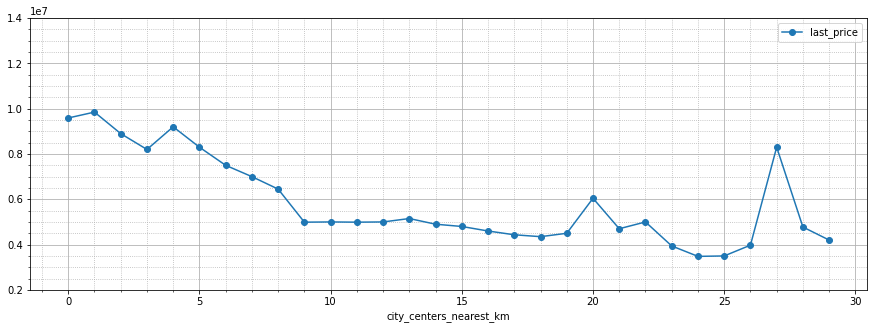

In [111]:
spb_flats.pivot_table(index='city_centers_nearest_km', 
                      values='last_price', 
                      aggfunc='median').plot(figsize=(15, 5),
                                             marker='o',
                                             grid=True,
                                             ylim=(2_000_000, 14_000_000))
plt.minorticks_on()
plt.grid(which='minor',
        linestyle=':')

По графику видно, что при удалении от центра города цена недвижимости снижается. С 0 по 9 км происходит более резкое снижение цены, с 9 по 26 более плавное снижение цены. на 20 и 27 км мы видим резкий рост медианной цены, скорее всего на этом расстоянии от центра нахотятся престижные районы с более высокой ценой на недвижимость.

**Были проанализированы данные в столбцах и выявлено следующее:**
-  `total_area`,  было выявлено, что медианные значения площадей квартир в зависимости от количества комнат схожи со стандартными планировками по площади.
- `kitchen_area` - кухни площадью в 6 - 12 кв.м являются наиболее встречаемыми и не сильно зависит от количества комнат
- `living_area`- по распределению встречается 3 моды, что может сказать о жилой площади для стандартных квартир с 1, 2 или 3 комнатами
- `rooms` - наиболее часто продаются квартиры с 1,2 и 3 комнатами
- `ceiling_height` - наиболее встречающиеся значения высоты потолка: 2.5, 2.6 и 3 м
- `floor` - наибольшее количество квартир продается в с 1 по 5 этажи, далее идут квартиры с 6 по 9 этаж и т.д
-  `floors_total`  - реобладают дома этажностью 5, 9, 12, 16 и 25 этажей
- `floor_category` - в центре города (до 3-х км от центра) преимущественно низкоэтажная застройка. На расстоянии 3 - 24 км дома различной этажности (до 30 этажей). На расстоянии большем 24 км от центра количество высоких домов снижается
- 'floor_category' - наибольшее количество квартир продаются на средних этажах
- `city_center_nearest_km` - самое большее количество квартир продается на расстоянии 10 - 16 км от цента города
- `parks_nearest` - до 20 км от центра, в среднем, расстояние до ближайшего парка составляет около 400 м.
- `weekday_of_publishing` - в выходные дни гораздо меньше публикуется объявлений
- `month_of_publishing` - В январе и мае наименьшее количество объявлений, к лету количество объявлений уменьшается, а зиме увеличивается
- `last_price` - наиболее встечающиеся цены на квартиры в диапазоне 3 - 5 млн.руб.
- `price_of_meter` - больше всего квартир с ценой за 1 кв.м в районе 80 - 100 тыс./кв.м. Медианная цена составляет 95 тыс.руб, средняя 99.4 тыс.руб.
- `days_exposition` - средний срок продажи квартиры составляет 180 дней, медианное значение равно 95 дням. Необычно долгой продажей сожно считать продажу дольше 500 дней, быстрыми считаются продажи менее чем за 45 дней

### Общий вывод

В ходе предобработки данных были приведены значения к общему стилю, изменены типы данных, в которых это было необходимо, заполнены пропуски или удалены строки с пропусками, которые нельзя было заполнить, часть пропусков не была заполнена, т.к. их нельзя адекватно заполнить, также были устранены аномальные значения.

Были добавлены новые столбцы в датасет, которые необходимы в дальнешем для анализа данных.

В ходе исследовательского анализа данных было проанализированы данные в столбцах, найдены взаимосвязи в данных и определены особенности в данных.

**Было выявлено:**

***На цену квартиры влияет:***
1. Общая площадь, с увеличением общей площади стоимость жилья растет.
2. Жилая площадь (тесно связана с общей площадью), - увеличением, цена растет.
3. Количество комнат (тесно связана с общей площадью), - увеличением, цена растет.
4. День недели и месяц публикации
5. Отдаленность от центра - с увеличением расстояния от центра цена квартиры уменьшается.

***На цену 1 кв.м влияет:***
1. Количество комнат, начиная со студий до 3 комнатных квартир цена за 1 кв.м снижается с увеличением количества комнат.
2. Общая площадь - с увеличением площади цена снижается.
3. Тип этажа - на первом этаже самая низкая цена за 1 кв.м, на среднем - самая высокая.
4. День недели и месяц публикации
5. От населенного пункта, самые дорогой кв.м. в Санкт-Петербурге

**Для более точного анализа данных не хватает данных:**
1. Тип дома (кирпичный, панельный, сталинский, монолитный)
2. Оценка ремонта квартиры
3. Тип оплаты (доступна ли ипотека или оплата наличными)
4. Расстояние до метро
5. Близость к загруженным дорогам
6. Водопровод (есть ли горячая вода или нужно использовать газовую колонку)